- 개발 환경(OS): Windows 10 Education, 64비트 운영 체제, x64 기반 프로세서
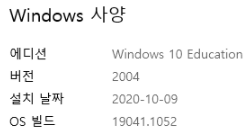

## Library version check

In [1]:
#!pip install --user sktime

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
import sys
import sktime
import tqdm as tq
import xgboost as xgb
import matplotlib
import seaborn as sns
import sklearn as skl
import pandas as pd
import numpy as np
print("-------------------------- Python & library version --------------------------")
print("Python version: {}".format(sys.version))
print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(matplotlib.__version__))
print("tqdm version: {}".format(tq.__version__))
print("sktime version: {}".format(sktime.__version__))
print("xgboost version: {}".format(xgb.__version__))
print("seaborn version: {}".format(sns.__version__))
print("scikit-learn version: {}".format(skl.__version__))
print("------------------------------------------------------------------------------")

-------------------------- Python & library version --------------------------
Python version: 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
pandas version: 1.4.4
numpy version: 1.22.4
matplotlib version: 3.5.2
tqdm version: 4.64.0
sktime version: 0.21.0
xgboost version: 1.4.2
seaborn version: 0.11.2
scikit-learn version: 0.24.2
------------------------------------------------------------------------------


## 0. load the libararies

In [4]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor

pd.set_option('display.max_columns', 30)

## 1. preprocessing the data

#####  - time series를 일반 regression 문제로 변환하기 위해 시간 관련 변수 추가(월 / 주 / 요일)
#####  - 전력소비량의 건물별 요일별 시간대별 평균 / 건물별 시간대별 평균 / 건물별 시간대별 표준편차 변수 추가
###### 건물별 요일별 시간대별 표준편차 / 건물별 평균 등 여러 통계량 생성 후 몇개 건물에 테스트, 최종적으로 성능 향상에 도움이 된 위 3개 변수만 추가
#####  - 공휴일 변수 추가
#####  - 시간(hour)는 cyclical encoding하여 변수 추가(sin time & cos time) 후 삭제
#####  - CDH(Cooling Degree Hour) & THI(불쾌지수) 변수 추가
##### - 건물별 모델 생성 시 무의미한 태양광 발전 시설 / 냉방시설 변수 삭제

In [5]:
train = pd.read_csv('전력사용량/train.csv')

In [6]:
buliding_info = pd.read_csv('building_info_processed.csv',index_col='Unnamed: 0')

In [7]:
buliding_info

,num,type_num,year_size,cool_size
0,1,0,110634.00,39570.00
1,2,0,122233.47,99000.00
2,3,0,171243.00,113950.00
3,4,0,74312.98,34419.62
4,5,0,205884.00,150000.00
...,...,...,...,...
95,96,11,93314.00,60500.00
96,97,11,55144.67,25880.00
97,98,11,53578.62,17373.75
98,99,11,53499.00,40636.00


In [8]:
train.drop(['num_date_time'],axis=1,inplace=True)

In [9]:
train.columns

Index(['건물번호', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)',
       '일사(MJ/m2)', '전력소비량(kWh)'],
      dtype='object')

In [10]:
train = train.reindex(columns=['건물번호', '일시','전력소비량(kWh)', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)',
       '일사(MJ/m2)'])

In [11]:
# 습도가 80 미만인 경우 강수량을 0으로 채우기
mask = (train['습도(%)'] < 90) & (train['강수량(mm)'].isnull())
train.loc[mask, '강수량(mm)'] = 0.0

train['강수량(mm)'] = train['강수량(mm)'].interpolate(method='linear')

train

,건물번호,일시,전력소비량(kWh),기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2)
0,1,20220601 00,1085.28,18.6,0.0,0.9,42.0,NaN,NaN
1,1,20220601 01,1047.36,18.0,0.0,1.1,45.0,NaN,NaN
2,1,20220601 02,974.88,17.7,0.0,1.5,45.0,NaN,NaN
3,1,20220601 03,953.76,16.7,0.0,1.4,48.0,NaN,NaN
4,1,20220601 04,986.40,18.4,0.0,2.8,43.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
203995,100,20220824 19,881.04,23.1,0.0,0.9,86.0,0.5,NaN
203996,100,20220824 20,798.96,22.4,0.0,1.3,86.0,0.0,NaN
203997,100,20220824 21,825.12,21.3,0.0,1.0,92.0,NaN,NaN
203998,100,20220824 22,640.08,21.0,0.0,0.3,94.0,NaN,NaN


In [12]:
# train['강수량(mm)'] = train['강수량(mm)'].fillna(0.0)

In [13]:
count_greater_than_zero = train[train['강수량(mm)'] > 0].shape[0]
count_greater_than_zero

31499

In [14]:
## 변수들을 영문명으로 변경
cols = ['num', 'date_time', 'power', 'temp', 'rain', 'wind', 'hum', 'solar_time', 'solar']
train.columns = cols

# 시간 관련 변수들 생성
date = pd.to_datetime(train.date_time)
train['hour'] = date.dt.hour
train['day'] = date.dt.weekday
train['month'] = date.dt.month
train['week'] = date.dt.weekofyear

#######################################
## 건물별, 요일별, 시간별 발전량 평균 넣어주기
#######################################
power_mean = pd.pivot_table(train, values = 'power', index = ['num', 'hour', 'day'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train['day_hour_mean'] = train.progress_apply(lambda x : power_mean.loc[(power_mean.num == x['num']) & (power_mean.hour == x['hour']) & (power_mean.day == x['day']) ,'power'].values[0], axis = 1)

#######################################
## 건물별 시간별 발전량 평균 넣어주기
#######################################
power_hour_mean = pd.pivot_table(train, values = 'power', index = ['num', 'hour'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train['hour_mean'] = train.progress_apply(lambda x : power_hour_mean.loc[(power_hour_mean.num == x['num']) & (power_hour_mean.hour == x['hour']) ,'power'].values[0], axis = 1)

#######################################
## 건물별 시간별 발전량 표준편차 넣어주기
#######################################
power_hour_std = pd.pivot_table(train, values = 'power', index = ['num', 'hour'], aggfunc = np.std).reset_index()
tqdm.pandas()
train['hour_std'] = train.progress_apply(lambda x : power_hour_std.loc[(power_hour_std.num == x['num']) & (power_hour_std.hour == x['hour']) ,'power'].values[0], axis = 1)

### 공휴일 변수 추가
train['holiday'] = train.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)
train.loc[('2022-08-15'<=train.date_time)&(train.date_time<'2022-08-16'), 'holiday'] = 1
train.loc[('2022-06-06'<=train.date_time)&(train.date_time<'2022-06-07'), 'holiday'] = 1

## https://dacon.io/competitions/official/235680/codeshare/2366?page=1&dtype=recent
train['sin_time'] = np.sin(2*np.pi*train.hour/24)
train['cos_time'] = np.cos(2*np.pi*train.hour/24)

## https://dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent
train['THI'] = 9/5*train['temp'] - 0.55*(1-train['hum']/100)*(9/5*train['hum']-26)+32

def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

cdhs = np.array([])
for num in range(1,101,1):
    temp = train[train['num'] == num]
    cdh = CDH(temp['temp'].values)
    cdhs = np.concatenate([cdhs, cdh])
train['CDH'] = cdhs

train.head()

100%|████████████████████████████████████████████████████████████████████████| 204000/204000 [00:29<00:00, 6831.63it/s]


,num,date_time,power,temp,rain,wind,hum,solar_time,solar,hour,day,month,week,day_hour_mean,hour_mean,hour_std,holiday,sin_time,cos_time,THI,CDH
0,1,20220601 00,1085.28,18.6,0.0,0.9,42.0,NaN,NaN,0,2,6,22,1774.744615,1706.318118,446.882767,0,0.000000,1.000000,49.6576,-7.4
1,1,20220601 01,1047.36,18.0,0.0,1.1,45.0,NaN,NaN,1,2,6,22,1687.347692,1622.620235,439.662704,0,0.258819,0.965926,47.7625,-15.4
2,1,20220601 02,974.88,17.7,0.0,1.5,45.0,NaN,NaN,2,2,6,22,1571.483077,1506.971294,412.071906,0,0.500000,0.866025,47.2225,-23.7
3,1,20220601 03,953.76,16.7,0.0,1.4,48.0,NaN,NaN,3,2,6,22,1522.153846,1437.365647,391.205981,0,0.707107,0.707107,44.7856,-33.0
4,1,20220601 04,986.40,18.4,0.0,2.8,43.0,NaN,NaN,4,2,6,22,1506.793846,1447.321412,381.099697,0,0.866025,0.500000,49.0061,-40.6


In [15]:
train.drop(['hour','solar_time', 'solar'], axis = 1, inplace = True)

In [16]:
train = train.merge(buliding_info, on='num', how='left')

In [17]:
# train.drop(['type_num'],axis=1,inplace=True)

In [18]:
train

,num,date_time,power,temp,rain,wind,hum,day,month,week,day_hour_mean,hour_mean,hour_std,holiday,sin_time,cos_time,THI,CDH,type_num,year_size,cool_size
0,1,20220601 00,1085.28,18.6,0.0,0.9,42.0,2,6,22,1774.744615,1706.318118,446.882767,0,0.000000,1.000000,49.6576,-7.4,0,110634.00,39570.00
1,1,20220601 01,1047.36,18.0,0.0,1.1,45.0,2,6,22,1687.347692,1622.620235,439.662704,0,0.258819,0.965926,47.7625,-15.4,0,110634.00,39570.00
2,1,20220601 02,974.88,17.7,0.0,1.5,45.0,2,6,22,1571.483077,1506.971294,412.071906,0,0.500000,0.866025,47.2225,-23.7,0,110634.00,39570.00
3,1,20220601 03,953.76,16.7,0.0,1.4,48.0,2,6,22,1522.153846,1437.365647,391.205981,0,0.707107,0.707107,44.7856,-33.0,0,110634.00,39570.00
4,1,20220601 04,986.40,18.4,0.0,2.8,43.0,2,6,22,1506.793846,1447.321412,381.099697,0,0.866025,0.500000,49.0061,-40.6,0,110634.00,39570.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,20220824 19,881.04,23.1,0.0,0.9,86.0,2,8,34,964.873846,1010.462118,161.399578,0,-0.965926,0.258819,63.6624,-19.6,11,57497.84,40035.23
203996,100,20220824 20,798.96,22.4,0.0,1.3,86.0,2,8,34,882.184615,928.125176,137.566008,0,-0.866025,0.500000,62.4024,-20.2,11,57497.84,40035.23
203997,100,20220824 21,825.12,21.3,0.0,1.0,92.0,2,8,34,779.095385,830.032941,128.300189,0,-0.707107,0.707107,64.1976,-22.3,11,57497.84,40035.23
203998,100,20220824 22,640.08,21.0,0.0,0.3,94.0,2,8,34,663.267692,723.100235,112.464079,0,-0.500000,0.866025,65.0744,-25.1,11,57497.84,40035.23


In [19]:
## save the preprocessed data
train.to_csv('전력사용량/train_preprocessed.csv')

In [20]:
train = pd.read_csv('전력사용량/train_preprocessed.csv',index_col='Unnamed: 0')

In [21]:
train

,num,date_time,power,temp,rain,wind,hum,day,month,week,day_hour_mean,hour_mean,hour_std,holiday,sin_time,cos_time,THI,CDH,type_num,year_size,cool_size
0,1,20220601 00,1085.28,18.6,0.0,0.9,42.0,2,6,22,1774.744615,1706.318118,446.882767,0,0.000000,1.000000,49.6576,-7.4,0,110634.00,39570.00
1,1,20220601 01,1047.36,18.0,0.0,1.1,45.0,2,6,22,1687.347692,1622.620235,439.662704,0,0.258819,0.965926,47.7625,-15.4,0,110634.00,39570.00
2,1,20220601 02,974.88,17.7,0.0,1.5,45.0,2,6,22,1571.483077,1506.971294,412.071906,0,0.500000,0.866025,47.2225,-23.7,0,110634.00,39570.00
3,1,20220601 03,953.76,16.7,0.0,1.4,48.0,2,6,22,1522.153846,1437.365647,391.205981,0,0.707107,0.707107,44.7856,-33.0,0,110634.00,39570.00
4,1,20220601 04,986.40,18.4,0.0,2.8,43.0,2,6,22,1506.793846,1447.321412,381.099697,0,0.866025,0.500000,49.0061,-40.6,0,110634.00,39570.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,20220824 19,881.04,23.1,0.0,0.9,86.0,2,8,34,964.873846,1010.462118,161.399578,0,-0.965926,0.258819,63.6624,-19.6,11,57497.84,40035.23
203996,100,20220824 20,798.96,22.4,0.0,1.3,86.0,2,8,34,882.184615,928.125176,137.566008,0,-0.866025,0.500000,62.4024,-20.2,11,57497.84,40035.23
203997,100,20220824 21,825.12,21.3,0.0,1.0,92.0,2,8,34,779.095385,830.032941,128.300189,0,-0.707107,0.707107,64.1976,-22.3,11,57497.84,40035.23
203998,100,20220824 22,640.08,21.0,0.0,0.3,94.0,2,8,34,663.267692,723.100235,112.464079,0,-0.500000,0.866025,65.0744,-25.1,11,57497.84,40035.23


강수량 결측 0으로 채움

#### sktime library으로 마지막 일주일을 validation set으로 설정

train data shape
x:(1872, 18), y:(1872,)
val data shape
x:(168, 18), y:(168,)


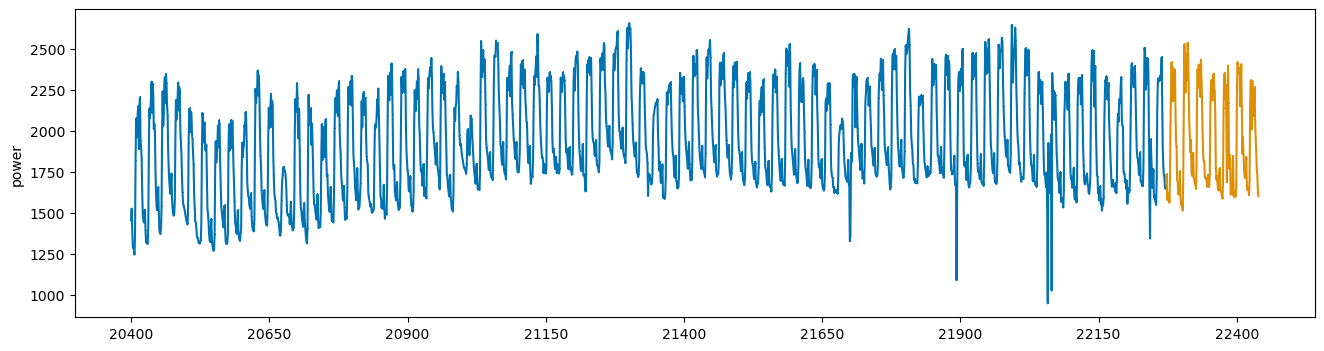

In [22]:
## 6번 건물의 발전량
y = train.loc[train.num == 11, 'power']
x = train.loc[train.num == 11, ].iloc[:, 3:]

y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168) # 24시간*7일 = 168

print('train data shape\nx:{}, y:{}'.format(x_train.shape, y_train.shape))
print('val data shape\nx:{}, y:{}'.format(x_valid.shape, y_valid.shape))

plot_series(y_train, y_valid, markers=[',' , ','])
plt.show()

train data shape
x:(1872, 18), y:(1872,)
val data shape
x:(168, 18), y:(168,)


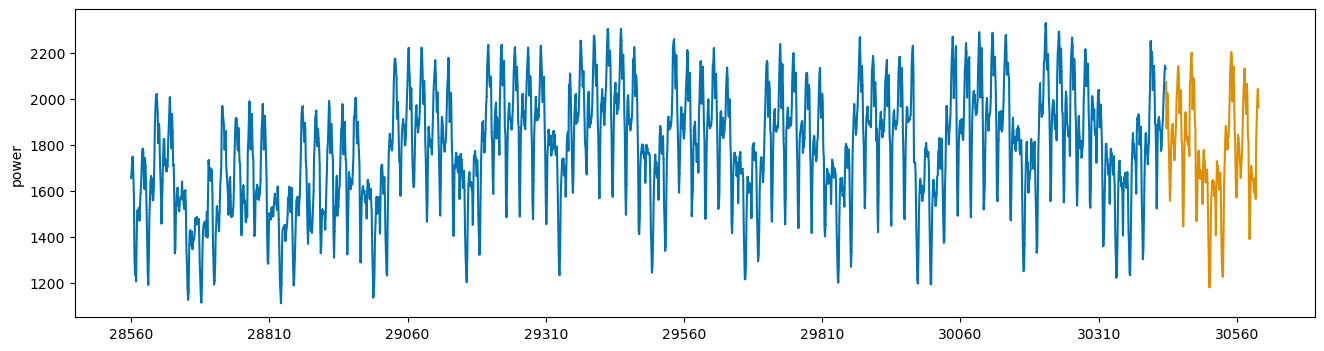

In [23]:
## 6번 건물의 발전량
y = train.loc[train.num == 15, 'power']
x = train.loc[train.num == 15, ].iloc[:, 3:]

y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168) # 24시간*7일 = 168

print('train data shape\nx:{}, y:{}'.format(x_train.shape, y_train.shape))
print('val data shape\nx:{}, y:{}'.format(x_valid.shape, y_valid.shape))

plot_series(y_train, y_valid, markers=[',' , ','])
plt.show()

train data shape
x:(1872, 18), y:(1872,)


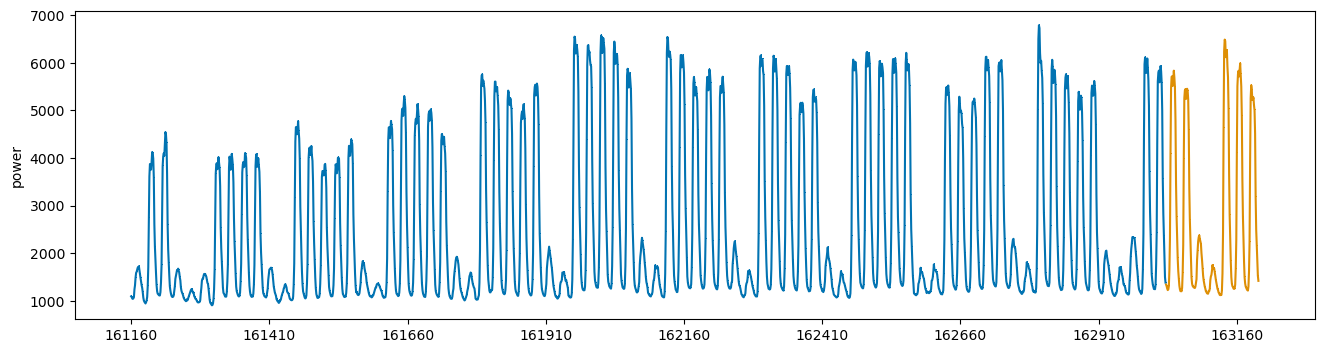

In [24]:
## 7번 건물의 발전량
y = train.loc[train.num == 80, 'power']
x = train.loc[train.num == 80, ].iloc[:, 3:]

y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168) # 24시간*7일 = 168

print('train data shape\nx:{}, y:{}'.format(x_train.shape, y_train.shape))

plot_series(y_train, y_valid, markers=[',' , ','])
plt.show()

train data shape
x:(1872, 18), y:(1872,)


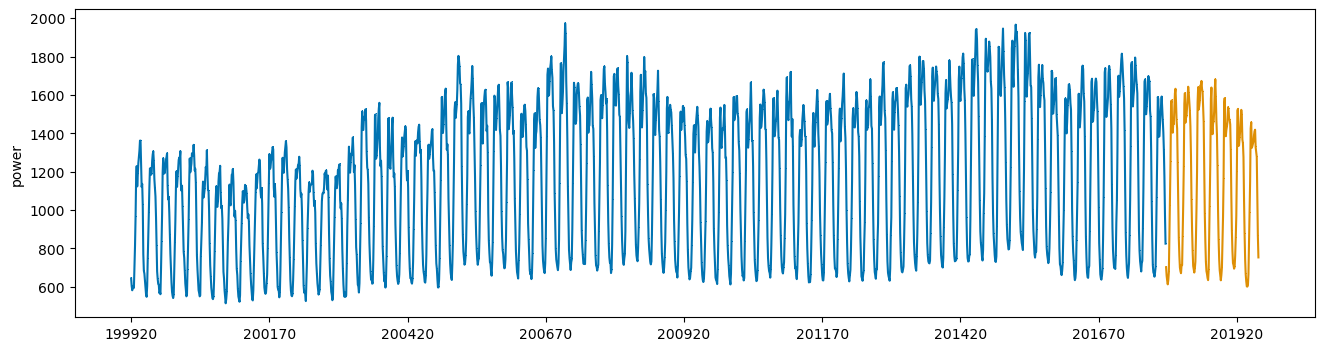

In [25]:
## 7번 건물의 발전량
y = train.loc[train.num == 99, 'power']
x = train.loc[train.num == 99, ].iloc[:, 3:]

y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168) # 24시간*7일 = 168

print('train data shape\nx:{}, y:{}'.format(x_train.shape, y_train.shape))

plot_series(y_train, y_valid, markers=[',' , ','])
plt.show()

## 2. Model : XGBoost

#### 모델은 시계열 데이터에 좋은 성능을 보이는 XGBoost를 선정했습니다. 

In [26]:
# Define SMAPE loss function
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

#### 아래와 같이 평가 Metric인 SMAPE는 실제값보다 작게 추정할 때 더 좋지 않습니다. 
#### 이는 전력사용량을 높게 예측하는 것보다 작게 예측할 때 실제로 더 큰 문제가 될 수 있음을 반영한 것으로 보입니다.

In [27]:
print("실제값이 100일 때 50으로 underestimate할 때의 SMAPE : {}".format(SMAPE(100, 50)))
print("실제값이 100일 때 150으로 overestimate할 때의 SMAPE : {}".format(SMAPE(100, 150)))

실제값이 100일 때 50으로 underestimate할 때의 SMAPE : 33.33333333333333
실제값이 100일 때 150으로 overestimate할 때의 SMAPE : 20.0


#### 그러나 일반 mse를 objective function으로 훈련할 때 과소추정하는 건물들이 있음을 확인했습니다.
#### 이때문에 SMAPE 점수가 높아진다고 판단, 이를 해결하기 위해 아래와 같이 objective function을 새로 정의했습니다.
#### 새 목적함수는 residual이 0보다 클 때, 즉 실제값보다 낮게 추정할 때 alpha만큼의 가중치를 곱해 반영합니다.

#### XGBoost는 custom objective function으로 훈련하기 위해선 아래와 같이 
#### gradient(1차 미분함수) / hessian(2차 미분함수)를 정의해 두 값을 return해주어야 합니다.

In [28]:
#### alpha를 argument로 받는 함수로 실제 objective function을 wrapping하여 alpha값을 쉽게 조정할 수 있도록 작성했습니다.
# custom objective function for forcing model not to underestimate
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

##### 기본 mse를 objective function으로 사용할 때 : SAMPE 12.7705

In [29]:
# xgb_params = pd.read_csv('./parameters/hyperparameter_xgb.csv')
xgb_reg = XGBRegressor(n_estimators = 10000, eta = 0.01, min_child_weight = 6, 
                       max_depth = 5, colsample_bytree = 0.8, 
                       subsample = 0.9, seed=0)

xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
        early_stopping_rounds=300,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.01, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.00999999978, max_delta_step=0, max_depth=5,
             min_child_weight=6, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=20, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
             subsample=0.9, tree_method='exact', validate_parameters=1,
             verbosity=None)

best iterations: 481
SMAPE : 1.4517828950668146


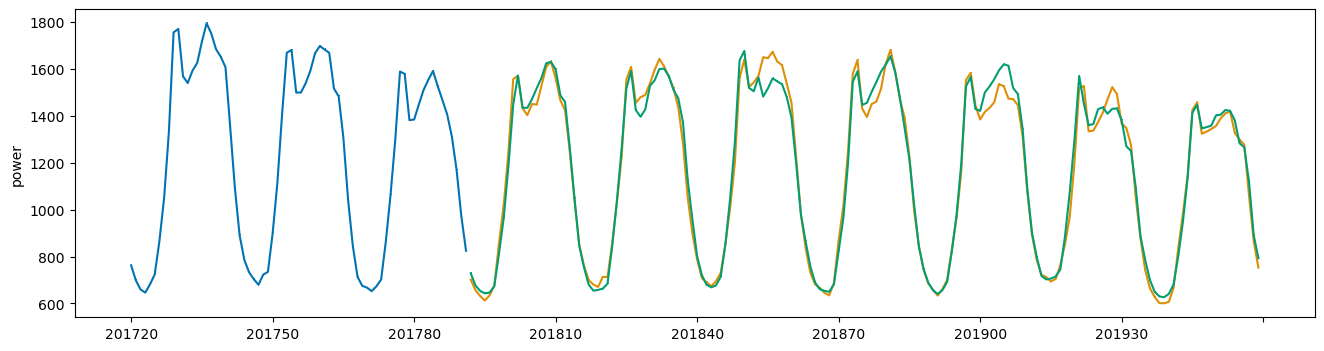

In [30]:
## 주황색이 실제 전력소비량, 초록색이 예측값입니다.
pred = xgb_reg.predict(x_valid)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train[1800:], y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('best iterations: {}'.format(xgb_reg.best_iteration))
print('SMAPE : {}'.format(SMAPE(y_valid, pred)))

##### with weighted mse(alpha = 100) : SMAPE 9.9390

In [31]:
xgb_reg = XGBRegressor(n_estimators = 10000, eta = 0.01, min_child_weight = 6, 
                       max_depth = 5, colsample_bytree = 0.8, 
                       subsample = 0.9, seed=0)

xgb_reg.set_params(**{'objective':weighted_mse(100)})

xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
        early_stopping_rounds=300,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.01, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.00999999978, max_delta_step=0, max_depth=5,
             min_child_weight=6, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=20, num_parallel_tree=1,
             objective=<function weighted_mse.<locals>.weighted_mse_fixed at 0x0000018DE67A81F0>,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=0, subsample=0.9, tree_method='exact', validate_parameters=1,
             verbosity=None)

best iterations: 389
SMAPE : 1.3873922547292847


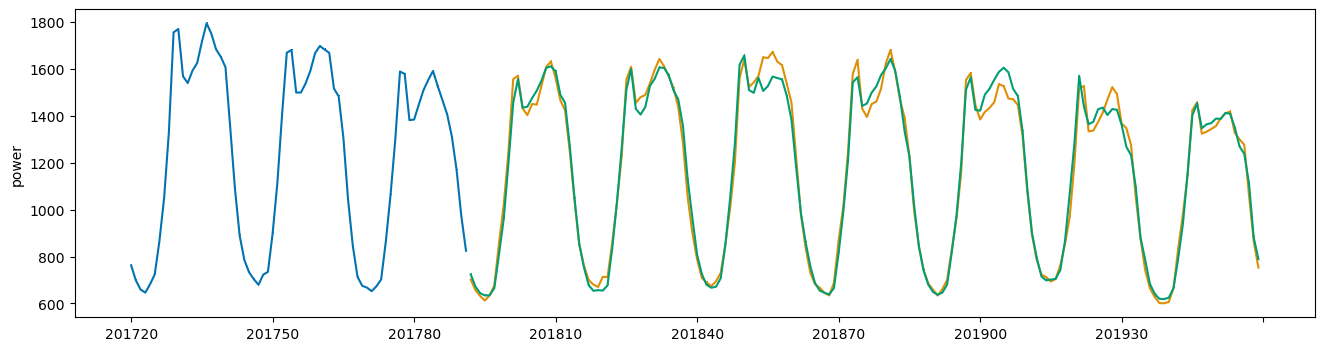

In [32]:
## SMAPE 값으로도, 그래프 상으로도 과소추정이 모델이 개선되었음을 확인
pred = xgb_reg.predict(x_valid)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train[1800:], y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('best iterations: {}'.format(xgb_reg.best_iteration))
print('SMAPE : {}'.format(SMAPE(y_valid, pred)))

## 3. model tuning

#### 다른 parameter를 고정하지 않고 전체 parameter를 튜닝하고자 하면 매우 오래걸리기 때문에 
#### 모델 내 hyperparameter들은 아래와 같이 sklearn의 gridsearchCV를 활용해 튜닝하고,
#### XGBoost의 early stopping 기능으로 n_estimators를 튜닝하고, 
#### weighted_mse의 alpha값을 튜닝했습니다.

#### ***참고***
##### gridsearch 코드는 빠른 튜닝을 위해 NIPA서버를 활용해 gpu버전으로 튜닝하여 cpu버전으로 찾은 parameter와는 값이 다릅니다.
###### (gpu와 cpu버전의 bootstrap 과정 등의 차이에 기인하는 것으로 생각됩니다.)
##### 그러므로 gridsearchCV 코드는 제출하되 튜닝된 parameter를 csv로 첨부합니다. 
##### 이후 모든 과정은 첨부된 csv에 저장된 paramter를 사용하여 훈련, 예측합니다.  

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204000 entries, 0 to 203999
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num            204000 non-null  int64  
 1   date_time      204000 non-null  object 
 2   power          204000 non-null  float64
 3   temp           204000 non-null  float64
 4   rain           204000 non-null  float64
 5   wind           203981 non-null  float64
 6   hum            203991 non-null  float64
 7   day            204000 non-null  int64  
 8   month          204000 non-null  int64  
 9   week           204000 non-null  int64  
 10  day_hour_mean  204000 non-null  float64
 11  hour_mean      204000 non-null  float64
 12  hour_std       204000 non-null  float64
 13  holiday        204000 non-null  int64  
 14  sin_time       204000 non-null  float64
 15  cos_time       204000 non-null  float64
 16  THI            203991 non-null  float64
 17  CDH            204000 non-nul

In [34]:
#train = train.fillna('ffill')

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204000 entries, 0 to 203999
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num            204000 non-null  int64  
 1   date_time      204000 non-null  object 
 2   power          204000 non-null  float64
 3   temp           204000 non-null  float64
 4   rain           204000 non-null  float64
 5   wind           203981 non-null  float64
 6   hum            203991 non-null  float64
 7   day            204000 non-null  int64  
 8   month          204000 non-null  int64  
 9   week           204000 non-null  int64  
 10  day_hour_mean  204000 non-null  float64
 11  hour_mean      204000 non-null  float64
 12  hour_std       204000 non-null  float64
 13  holiday        204000 non-null  int64  
 14  sin_time       204000 non-null  float64
 15  cos_time       204000 non-null  float64
 16  THI            203991 non-null  float64
 17  CDH            204000 non-nul

In [ ]:
## gridsearchCV for best model : 대략 1시간 소요

from sklearn.model_selection import PredefinedSplit, GridSearchCV
df = pd.DataFrame(columns = ['n_estimators', 'eta', 'min_child_weight','max_depth', 'colsample_bytree', 'subsample'])
preds = np.array([])

grid = {'n_estimators' : [100], 'eta' : [0.01], 'min_child_weight' : np.arange(1, 8, 1), 
        'max_depth' : np.arange(3,9,1) , 'colsample_bytree' :np.arange(0.8, 1.0, 0.1), 
        'subsample' :np.arange(0.8, 1.0, 0.1)} # fix the n_estimators & eta(learning rate)
        
for i in tqdm(np.arange(1, 101)):
    y = train.loc[train.num == i, 'power']
    x = train.loc[train.num == i, ].iloc[:, 3:]  
    y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)
        
    pds = PredefinedSplit(np.append(-np.ones(len(x)-168), np.zeros(168)))
    gcv = GridSearchCV(estimator = XGBRegressor(seed = 0, gpu_id = 1, 
                                                tree_method = 'gpu_hist', predictor= 'gpu_predictor'),
                       param_grid = grid, scoring = SMAPE, cv = pds, refit = True, verbose = True)
    
    
    gcv.fit(x, y)
    best = gcv.best_estimator_
    params = gcv.best_params_
    print(params)
    pred = best.predict(x_test)
    building = 'building'+str(i)
    print(building + '|| SMAPE : {}'.format(SMAPE(y_test, pred)))
    preds = np.append(preds, pred)
    df = pd.concat([df, pd.DataFrame(params, index = [0])], axis = 0)
    df.to_csv('./hyperparameter_xgb.csv', index = False) # save the tuned parameters


In [37]:
xgb_params = pd.read_csv('./hyperparameter_xgb.csv')

### find the bset iteration (given alpha = 100)

In [38]:
scores = []   # smape 값을 저장할 list
best_it = []  # best interation을 저장할 list
for i in tqdm(range(100)):
    y = train.loc[train.num == i+1, 'power']
    x = train.loc[train.num == i+1, ].iloc[:, 3:]
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)
    
    xgb_reg = XGBRegressor(n_estimators = 10000, eta = 0.01, min_child_weight = xgb_params.iloc[i, 2],
                           max_depth = xgb_params.iloc[i, 3], colsample_bytree = xgb_params.iloc[i, 4], 
                           subsample = xgb_params.iloc[i, 5], seed=0)
    xgb_reg.set_params(**{'objective':weighted_mse(100)}) # alpha = 100으로 고정
    
    xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), 
                                            (x_valid, y_valid)], early_stopping_rounds=300, verbose=False)
    y_pred = xgb_reg.predict(x_valid)
    pred = pd.Series(y_pred)   
    
    sm = SMAPE(y_valid, y_pred)
    scores.append(sm)
    best_it.append(xgb_reg.best_iteration) ## 실제 best iteration은 이 값에 +1 해주어야 함.

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.12it/s]


### alpha tuning for weighted MSE

In [ ]:
alpha_list = []
smape_list = []
for i in tqdm(range(100)):
    y = train.loc[train.num == i+1, 'power']
    x = train.loc[train.num == i+1, ].iloc[:, 3:]
    y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)
    xgb = XGBRegressor(seed = 0,
                      n_estimators = best_it[i], eta = 0.01, min_child_weight = xgb_params.iloc[i, 2],
                      max_depth = xgb_params.iloc[i, 3], colsample_bytree = xgb_params.iloc[i, 4], subsample = xgb_params.iloc[i, 5])
    
    xgb.fit(x_train, y_train)
    pred0 = xgb.predict(x_test)
    best_alpha = 0
    score0 = SMAPE(y_test,pred0)
    
    for j in [1, 3, 5, 7, 10, 25, 50, 75, 100, 300]:
        xgb = XGBRegressor(seed = 0,
                      n_estimators = best_it[i], eta = 0.01, min_child_weight = xgb_params.iloc[i, 2],
                      max_depth = xgb_params.iloc[i, 3], colsample_bytree = xgb_params.iloc[i, 4], subsample = xgb_params.iloc[i, 5])
        xgb.set_params(**{'objective' : weighted_mse(j)})
    
        xgb.fit(x_train, y_train)
        pred1 = xgb.predict(x_test)
        score1 = SMAPE(y_test, pred1)
        if score1 < score0:
            best_alpha = j
            score0 = score1
    
    alpha_list.append(best_alpha)
    smape_list.append(score0)
    print("building {} || best score : {} || alpha : {}".format(i+1, score0, best_alpha))

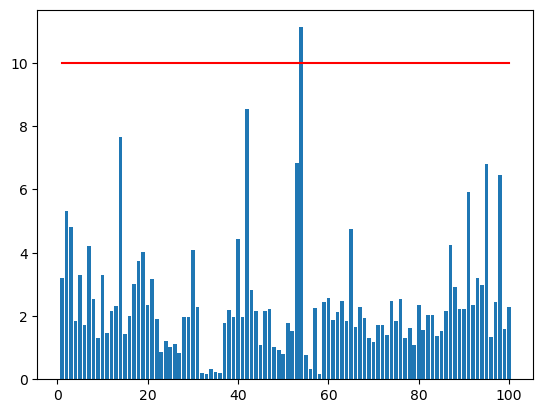

In [40]:
no_df = pd.DataFrame({'score':smape_list})
plt.bar(np.arange(len(no_df))+1, no_df['score'])
plt.plot([1,100], [10, 10], color = 'red')

## 4. test inference

### preprocessing for test data

In [41]:
test = pd.read_csv('전력사용량/test.csv')

In [42]:
test

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77
...,...,...,...,...,...,...,...
16795,100_20220831 19,100,20220831 19,22.5,0.0,0.9,84
16796,100_20220831 20,100,20220831 20,20.7,0.0,0.4,95
16797,100_20220831 21,100,20220831 21,20.2,0.0,0.4,98
16798,100_20220831 22,100,20220831 22,20.1,0.0,1.1,97


In [43]:
# train set과 동일한 전처리 과정
test.drop(['num_date_time'],axis=1,inplace=True)
cols = ['num', 'date_time', 'temp', 'rain', 'wind', 'hum']
test.columns = cols
date = pd.to_datetime(test.date_time)
test['hour'] = date.dt.hour
test['day'] = date.dt.weekday
test['month'] = date.dt.month
test['week'] = date.dt.weekofyear
test['sin_time'] = np.sin(2*np.pi*test.hour/24)
test['cos_time'] = np.cos(2*np.pi*test.hour/24)
test['holiday'] = test.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)

## 건물별 일별 시간별 발전량 평균
tqdm.pandas()
test['day_hour_mean'] = test.progress_apply(lambda x : power_mean.loc[(power_mean.num == x['num']) & (power_mean.day == x['day']) & (power_mean.hour == x['hour']) ,'power'].values[0], axis = 1)

## 건물별 시간별 발전량 평균 넣어주기
tqdm.pandas()
test['hour_mean'] = test.progress_apply(lambda x : power_hour_mean.loc[(power_hour_mean.num == x['num']) & (power_hour_mean.hour == x['hour']) ,'power'].values[0], axis = 1)

tqdm.pandas()
test['hour_std'] = test.progress_apply(lambda x : power_hour_std.loc[(power_hour_std.num == x['num']) & (power_hour_std.hour == x['hour']) ,'power'].values[0], axis = 1)

test.drop(['hour','date_time'], axis = 1, inplace = True)

# pandas 내 선형보간 method 사용
for i in range(100):
    test.iloc[i*168:(i+1)*168, :]  = test.iloc[i*168:(i+1)*168, :].interpolate()


test['THI'] = 9/5*test['temp'] - 0.55*(1-test['hum']/100)*(9/5*test['hum']-26)+32

cdhs = np.array([])
for num in range(1,101,1):
    temp = test[test['num'] == num]
    cdh = CDH(temp['temp'].values)
    cdhs = np.concatenate([cdhs, cdh])
test['CDH'] = cdhs

test = test[['num','temp', 'rain', 'wind', 'hum', 'day', 'month', 'week',
       'day_hour_mean', 'hour_mean', 'hour_std', 'holiday', 'sin_time',
       'cos_time', 'THI', 'CDH']]
test.head()

100%|██████████████████████████████████████████████████████████████████████████| 16800/16800 [00:02<00:00, 6709.14it/s]


,num,temp,rain,wind,hum,day,month,week,day_hour_mean,hour_mean,hour_std,holiday,sin_time,cos_time,THI,CDH
0,1,23.5,0.0,2.2,72,3,8,34,1627.80,1706.318118,446.882767,0,0.000000,1.000000,58.3456,-2.5
1,1,23.0,0.0,0.9,72,3,8,34,1550.08,1622.620235,439.662704,0,0.258819,0.965926,57.4456,-5.5
2,1,22.7,0.0,1.5,75,3,8,34,1431.12,1506.971294,412.071906,0,0.500000,0.866025,57.8725,-8.8
3,1,22.1,0.0,1.3,78,3,8,34,1372.20,1437.365647,391.205981,0,0.707107,0.707107,57.9376,-12.7
4,1,21.8,0.0,1.0,77,3,8,34,1381.72,1447.321412,381.099697,0,0.866025,0.500000,56.9961,-16.9


In [44]:
test = test.merge(buliding_info, on='num', how='left')

In [45]:
xgb_params['alpha'] = alpha_list
xgb_params['best_it'] = best_it
xgb_params.head()

,n_estimators,eta,min_child_weight,max_depth,colsample_bytree,subsample,alpha,best_it
0,100,0.01,1,3,0.8,0.8,1,348
1,100,0.01,1,3,0.8,0.8,10,246
2,100,0.01,1,3,0.8,0.8,7,203
3,100,0.01,1,3,0.8,0.8,50,316
4,100,0.01,1,3,0.8,0.8,10,366


In [46]:
xgb_params.to_csv('./hyperparameter_xgb_final.csv', index=False)

In [47]:
## best hyperparameters 불러오기
xgb_params = pd.read_csv('./hyperparameter_xgb_final.csv')
xgb_params.head()

,n_estimators,eta,min_child_weight,max_depth,colsample_bytree,subsample,alpha,best_it
0,100,0.01,1,3,0.8,0.8,1,348
1,100,0.01,1,3,0.8,0.8,10,246
2,100,0.01,1,3,0.8,0.8,7,203
3,100,0.01,1,3,0.8,0.8,50,316
4,100,0.01,1,3,0.8,0.8,10,366


In [48]:
best_it = xgb_params['best_it'].to_list()
best_it[0]      

348

### seed ensemble
#### - seed별로 예측값이 조금씩 바뀝니다. 
#### - seed의 영향을 제거하기 위해 6개의 seed(0부터 5)별로 훈련, 예측하여 6개 예측값의 평균을 구했습니다.

In [49]:
train = pd.read_csv('전력사용량/train_preprocessed.csv',index_col='Unnamed: 0')

In [50]:
# train.drop(['rain', 'solar_time', 'solar'],axis=1,inplace=True)

In [51]:
buliding_info.columns

Index(['num', 'type_num', 'year_size', 'cool_size'], dtype='object')

In [52]:
train = train.reindex(columns=['num', 'date_time', 'power', 'temp','rain', 'wind', 'hum', 'day', 'month',
       'week', 'day_hour_mean', 'hour_mean', 'hour_std', 'holiday', 'sin_time',
       'cos_time', 'THI', 'CDH','type_num', 'year_size', 'cool_size'])

In [53]:
x_train, x_test = train.loc[train.num == i+1, ].iloc[:, 2:], test.loc[test.num == i+1, ].iloc[:,1:]

In [54]:
x_train

,power,temp,rain,wind,hum,day,month,week,day_hour_mean,hour_mean,hour_std,holiday,sin_time,cos_time,THI,CDH,type_num,year_size,cool_size
201960,372.00,15.0,0.0,0.3,70.0,2,6,22,425.335385,450.982588,57.618897,0,0.000000,1.000000,42.5000,-11.0,11,57497.84,40035.23
201961,333.36,14.2,0.0,0.1,75.0,2,6,22,387.507692,404.450824,48.260651,0,0.258819,0.965926,42.5725,-22.8,11,57497.84,40035.23
201962,320.64,13.5,0.0,0.1,77.0,2,6,22,370.393846,381.910588,46.060484,0,0.500000,0.866025,42.0561,-35.3,11,57497.84,40035.23
201963,311.04,13.4,0.0,0.2,81.0,2,6,22,362.695385,372.900706,44.517603,0,0.707107,0.707107,43.6009,-47.9,11,57497.84,40035.23
201964,312.48,13.8,0.0,0.2,79.0,2,6,22,361.403077,369.554824,42.833213,0,0.866025,0.500000,43.4189,-60.1,11,57497.84,40035.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,881.04,23.1,0.0,0.9,86.0,2,8,34,964.873846,1010.462118,161.399578,0,-0.965926,0.258819,63.6624,-19.6,11,57497.84,40035.23
203996,798.96,22.4,0.0,1.3,86.0,2,8,34,882.184615,928.125176,137.566008,0,-0.866025,0.500000,62.4024,-20.2,11,57497.84,40035.23
203997,825.12,21.3,0.0,1.0,92.0,2,8,34,779.095385,830.032941,128.300189,0,-0.707107,0.707107,64.1976,-22.3,11,57497.84,40035.23
203998,640.08,21.0,0.0,0.3,94.0,2,8,34,663.267692,723.100235,112.464079,0,-0.500000,0.866025,65.0744,-25.1,11,57497.84,40035.23


In [55]:
x_test

,temp,rain,wind,hum,day,month,week,day_hour_mean,hour_mean,hour_std,holiday,sin_time,cos_time,THI,CDH,type_num,year_size,cool_size
16632,20.2,0.0,0.0,97,3,8,34,435.780000,450.982588,57.618897,0,0.000000,1.000000,65.9081,-5.8,11,57497.84,40035.23
16633,19.7,0.0,0.1,99,3,8,34,392.640000,404.450824,48.260651,0,0.258819,0.965926,66.6229,-12.1,11,57497.84,40035.23
16634,19.4,0.0,0.1,99,3,8,34,369.300000,381.910588,46.060484,0,0.500000,0.866025,66.0829,-18.7,11,57497.84,40035.23
16635,19.2,0.0,0.0,100,3,8,34,361.380000,372.900706,44.517603,0,0.707107,0.707107,66.5600,-25.5,11,57497.84,40035.23
16636,19.0,0.0,0.0,100,3,8,34,360.040000,369.554824,42.833213,0,0.866025,0.500000,66.2000,-32.5,11,57497.84,40035.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,22.5,0.0,0.9,84,2,8,35,964.873846,1010.462118,161.399578,0,-0.965926,0.258819,61.4824,-34.5,11,57497.84,40035.23
16796,20.7,0.0,0.4,95,2,8,35,882.184615,928.125176,137.566008,0,-0.866025,0.500000,65.2725,-34.4,11,57497.84,40035.23
16797,20.2,0.0,0.4,98,2,8,35,779.095385,830.032941,128.300189,0,-0.707107,0.707107,66.7056,-35.3,11,57497.84,40035.23
16798,20.1,0.0,1.1,97,2,8,35,663.267692,723.100235,112.464079,0,-0.500000,0.866025,65.7281,-36.8,11,57497.84,40035.23


In [56]:
preds = np.array([]) 
for i in tqdm(range(100)):
    
    pred_df = pd.DataFrame()   # 시드별 예측값을 담을 data frame
    
    for seed in [0,1,2,3,4,5]: # 각 시드별 예측
        y_train = train.loc[train.num == i+1, 'power']
        x_train, x_test = train.loc[train.num == i+1, ].iloc[:, 3:], test.loc[test.num == i+1, ].iloc[:,1:]
        # x_test = x_test[x_train.columns]
        
        xgb = XGBRegressor(seed = seed, n_estimators = best_it[i], eta = 0.01, 
                           min_child_weight = xgb_params.iloc[i, 2], max_depth = xgb_params.iloc[i, 3], 
                           colsample_bytree=xgb_params.iloc[i, 4], subsample=xgb_params.iloc[i, 5])
    
        if xgb_params.iloc[i,6] != 0:  # 만약 alpha가 0이 아니면 weighted_mse 사용
            xgb.set_params(**{'objective':weighted_mse(xgb_params.iloc[i,6])})
        
        xgb.fit(x_train, y_train)
        y_pred = xgb.predict(x_test)
        pred_df.loc[:,seed] = y_pred   # 각 시드별 예측 담기
        
    pred = pred_df.mean(axis=1)        # (i+1)번째 건물의 예측 =  (i+1)번째 건물의 각 시드별 예측 평균값
    preds = np.append(preds, pred)   

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:39<00:00,  2.79s/it]


In [57]:
"""
preds = pd.Series(preds)

fig, ax = plt.subplots(60, 1, figsize=(100,200), sharex = True)
ax = ax.flatten()
for i in range(100):
    train_y = train.loc[train.num == i+1, 'power'].reset_index(drop = True)
    test_y = preds[i*168:(i+1)*168]
    ax[i].scatter(np.arange(2040) , train.loc[train.num == i+1, 'power'])
    ax[i].scatter(np.arange(2040, 2040+168) , test_y)
    ax[i].tick_params(axis='both', which='major', labelsize=6)
    ax[i].tick_params(axis='both', which='minor', labelsize=4)
#plt.savefig('./predict_xgb.png')
plt.show()
"""

"\npreds = pd.Series(preds)\n\nfig, ax = plt.subplots(60, 1, figsize=(100,200), sharex = True)\nax = ax.flatten()\nfor i in range(100):\n    train_y = train.loc[train.num == i+1, 'power'].reset_index(drop = True)\n    test_y = preds[i*168:(i+1)*168]\n    ax[i].scatter(np.arange(2040) , train.loc[train.num == i+1, 'power'])\n    ax[i].scatter(np.arange(2040, 2040+168) , test_y)\n    ax[i].tick_params(axis='both', which='major', labelsize=6)\n    ax[i].tick_params(axis='both', which='minor', labelsize=4)\n#plt.savefig('./predict_xgb.png')\nplt.show()\n"

In [58]:
submission = pd.read_csv('전력사용량/sample_submission.csv')
submission['answer'] = preds
submission.to_csv('submission/submission_xgb_noclip_0728.csv', index = False)

## 5. post processing

#### weighted mse와 같은 맥락에서, 과도한 underestimate를 막기 위해 예측값을 후처리했습니다.
##### - 예측 주로부터 직전 4주(train set 마지막 28일)의 건물별 요일별 시간대별 전력소비량의 최솟값을 구한 뒤, 
##### - test set의 같은 건물 요일 시간대의 예측값과 비교하여 만약 1번의 최솟값보다 예측값이 작다면 최솟값으로 예측값을 대체해주었습니다.
##### - public score 0.01 , private score 0.08 정도의 성능 향상이 있었습니다.

In [95]:
train_to_post = pd.read_csv('전력사용량/train.csv')
train_to_post.drop(['num_date_time'],axis=1,inplace=True)
cols = ['num', 'date_time', 'temp', 'rain', 'wind', 'hum', 'solar_time', 'solar', 'power']
train_to_post.columns = cols
date = pd.to_datetime(train_to_post.date_time)
train_to_post['hour'] = date.dt.hour
train_to_post['day'] = date.dt.weekday
train_to_post['month'] = date.dt.month
train_to_post['week'] = date.dt.weekofyear
train_to_post = train_to_post.loc[(('2022-08-15'>train_to_post.date_time)|(train_to_post.date_time>='2022-08-16')), ].reset_index(drop = True)
train_to_post = train_to_post.loc[(('2022-06-06'>train_to_post.date_time)|(train_to_post.date_time>='2022-06-07')), ].reset_index(drop = True)

pred_clip = []
test_to_post = pd.read_csv('전력사용량/test.csv')
test_to_post.drop(['num_date_time'],axis=1,inplace=True)
cols = ['num', 'date_time', 'temp', 'rain', 'wind', 'hum']
test_to_post.columns = cols
date = pd.to_datetime(test_to_post.date_time)
test_to_post['hour'] = date.dt.hour
test_to_post['day'] = date.dt.weekday
test_to_post['month'] = date.dt.month
test_to_post['week'] = date.dt.weekofyear

## submission 불러오기
df = pd.read_csv('submission/submission_xgb_noclip_0728.csv')
for i in range(100):
    min_data = train_to_post.loc[train_to_post.num == i+1, ].iloc[-28*24:, :] ## 건물별로 직전 28일의 데이터 불러오기
    
    ## 요일별, 시간대별 최솟값 계산
    min_data = pd.pivot_table(min_data, values = 'power', index = ['day', 'hour'], aggfunc = min).reset_index() 
    
    pred = df.answer[168*i:168*(i+1)].reset_index(drop=True) ## 168개 데이터, 즉 건물별 예측값 불러오기
    
    day =  test_to_post.day[168*i:168*(i+1)].reset_index(drop=True) ## 예측값 요일 불러오기
    
    hour = test_to_post.hour[168*i:168*(i+1)].reset_index(drop=True) ## 예측값 시간 불러오기
    
    df_pred = pd.concat([pred, day, hour], axis = 1)
    df_pred.columns = ['pred', 'day', 'hour']
    
    # Example: Reduce each prediction by 10%
    for j in range(len(df_pred)):
        pred_clip.append(df_pred.pred[j] * 0.98)  # 10% reduction



##### 초록색으로 표시된 값이 원래의 예측값, 주황색이 후처리된 예측값입니다.
##### 변동이 거의 없는 건물도 있으나, 유의미하게 바뀐 건물도 확인됩니다. 

In [ ]:
pred_origin = df.answer
pred_clip = pd.Series(pred_clip)

for i in range(100):
    power = train_to_post.loc[train_to_post.num == i+1, 'power'].reset_index(drop=True)
    preds = pred_clip[i*168:(i+1)*168]
    preds_origin = pred_origin[i*168:(i+1)*168]
    preds.index = range(power.index[-1], power.index[-1]+168)
    preds_origin.index = range(power.index[-1], power.index[-1]+168)
    
    plot_series(power, preds,  preds_origin, markers = [',', ',', ','])
    plt.xlim([preds.index[-168], preds.index[-1]])  # limit to last 60

#### create submission file 

In [97]:
submission = pd.read_csv('전력사용량/sample_submission.csv')
submission['answer'] = pred_clip
submission.to_csv('submission/submission_xgb_final_0801_0.98.csv', index = False)